# Practical Unit 2

## Pipeline Overview

1. **Initialize Setup**
    - `seed`, `device`, ...
2. **Load datasets**
    - same transformation, augmentation, ... for pre-training and fine-tuning
3. **Build CoAtNet**
    - adjust for pre-training and fine-tuning accordingly 
4. **Pre-Training**
    - Train-Loop
    - Evaluation
    - Save best pre-trained Model
5. **Fine-Tuning**
    - Train-Loop
    - Evaluation
    - Save best fine-tuned Model


### Hints
> I added all **helpers functions** from the other ipynb-Tutorials to this branch. So if you want, you can **access and reuse** them. But if they don't fit, **please don't change them**! Just create a new python file, write there your function and afterwards import them to this ipynb.

> Please **insert all imports** inside of the [Initialize Setup](#1-initialize-setup) to prevent confusion and double imports.

## 1. Initialize Setup

- [x] prepare `imports` (*please insert all imports here to prevent confusion*)
- [x] set `root_path`
- [x] set seed with `set_seed`
- [x] set `device` to `cuda`, if cuda is available

In [1]:
# Imports
import os, sys
from Utils.little_helpers import set_seed
import torch
import kagglehub
from torchvision import transforms
import torchvision.transforms.v2 as v2
import pandas as pd
from Utils.preparation import create_df_with_age_categories, plot_class_distribution, create_class_weights, plot_class_weights, create_datasets_loader, plot_images_with_labels_and_filenames
from sklearn.model_selection import train_test_split

# Set root_path
notebook_dir = os.getcwd()
root_path = os.path.abspath(os.path.join(notebook_dir, "."))
if root_path not in sys.path:
    sys.path.append(root_path)
    print(f"Added {root_path} to sys.path")

# Set seed
set_seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'PyTorch version: {torch.__version__} running on {device}')

Added p:\repositories\dlfp_age_task to sys.path
PyTorch version: 2.7.0+cu128 running on cuda


## 2. Load and prepare Datasets
> The connection to kagglehub is quite easy. Just follow the instructions on kagglehub or here in the output prompt. Optionally you can just download the zip and extract the contents to the `datasets` folder. 

- [x] connect to kagglehub
- [x] create transform (for train)
- [x] create transform (for test/eval)
- [x] UTKFace
  - [x] load UTKFace
  - [x] create Dataframe with `age_category`
  - [x] split train, val, test
  - [x] create class weights
  - [x] create Dataset
- [ ] AgeDB
  - [x] load AgeDB
  - [x] create Dataframe with `age_category`
  - [x] split train, val, test
  - [x] create class weights
  - [x] create Dataset

Connect to kagglehub and download both datasets:

In [2]:
# Connect to kagglehub and download datasets

# Create datasets directory if it doesn't exist
dataset_path = os.path.join(notebook_dir, "datasets")
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)
    print(f"Created directory: {dataset_path}")

# Set download path for kagglehub 
os.environ["KAGGLEHUB_CACHE"] = dataset_path

# Download datasets from kagglehub
utkface_download_path = kagglehub.dataset_download("jangedoo/utkface-new")
utkface_path = os.path.join(utkface_download_path, "UTKFace")
print(f"UTKFace dataset downloaded to: {utkface_path}")

agedb_download_path = kagglehub.dataset_download("nitingandhi/agedb-database")
agedb_path = os.path.join(agedb_download_path, "AgeDB")
print(f"AgeDB dataset downloaded to: {agedb_path}")

UTKFace dataset downloaded to: p:\repositories\dlfp_age_task\datasets\datasets\jangedoo\utkface-new\versions\1\UTKFace
AgeDB dataset downloaded to: p:\repositories\dlfp_age_task\datasets\datasets\nitingandhi\agedb-database\versions\1\AgeDB


Define transformation, augmentation and normalization (for train and test):

In [3]:
transform_train = transforms.Compose([
    v2.ToImage(),
    
    # Core transformations
    v2.RandomResizedCrop(size=224, scale=(0.75, 1.0), ratio=(0.9, 1.05)),
    v2.RandomHorizontalFlip(p=0.5),  # People can face either direction
    v2.RandomRotation(degrees=(-10, 10)),  # Small rotations
    
    # Lighting and appearance variations
    v2.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.1, hue=0.05),
    v2.RandomAutocontrast(p=0.2),
    
    # Occasional realistic variations - with proper probability handling
    v2.RandomApply([v2.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))], p=0.3),
    v2.RandomAdjustSharpness(sharpness_factor=1.5, p=0.3),
    v2.RandomPerspective(distortion_scale=0.15, p=0.3),
    v2.RandomErasing(p=0.1, scale=(0.02, 0.08), ratio=(0.3, 3.3)),
    
    # Normalization
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(size=(224,224)),
    v2.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229,0.224,0.225]) , 
])

Create pandas dataframes (df) from both datasets:

In [4]:
# Create DataFrames with age categories
pd.set_option('display.max_colwidth', None)  # Show all columns in DataFrame
utkface_df = create_df_with_age_categories(utkface_path)
utkface_df.head()
# print(utkface_df.describe())


,image_path,age,age_category
0,p:\repositories\dlfp_age_task\datasets\datasets\jangedoo\utkface-new\versions\1\UTKFace\100_0_0_20170112213500903.jpg.chip.jpg,100,>60
1,p:\repositories\dlfp_age_task\datasets\datasets\jangedoo\utkface-new\versions\1\UTKFace\100_0_0_20170112215240346.jpg.chip.jpg,100,>60
2,p:\repositories\dlfp_age_task\datasets\datasets\jangedoo\utkface-new\versions\1\UTKFace\100_1_0_20170110183726390.jpg.chip.jpg,100,>60
3,p:\repositories\dlfp_age_task\datasets\datasets\jangedoo\utkface-new\versions\1\UTKFace\100_1_0_20170112213001988.jpg.chip.jpg,100,>60
4,p:\repositories\dlfp_age_task\datasets\datasets\jangedoo\utkface-new\versions\1\UTKFace\100_1_0_20170112213303693.jpg.chip.jpg,100,>60


In [5]:
agedb_df = create_df_with_age_categories(agedb_path)
agedb_df.head()
# print(agedb_df.describe())

,image_path,age,age_category
0,p:\repositories\dlfp_age_task\datasets\datasets\nitingandhi\agedb-database\versions\1\AgeDB\0_MariaCallas_35_f.jpg,35,18-40
1,p:\repositories\dlfp_age_task\datasets\datasets\nitingandhi\agedb-database\versions\1\AgeDB\10000_GlennClose_62_f.jpg,62,>60
2,p:\repositories\dlfp_age_task\datasets\datasets\nitingandhi\agedb-database\versions\1\AgeDB\10001_GoldieHawn_23_f.jpg,23,18-40
3,p:\repositories\dlfp_age_task\datasets\datasets\nitingandhi\agedb-database\versions\1\AgeDB\10002_GoldieHawn_24_f.jpg,24,18-40
4,p:\repositories\dlfp_age_task\datasets\datasets\nitingandhi\agedb-database\versions\1\AgeDB\10003_GoldieHawn_24_f.jpg,24,18-40


Split both df in train, val and test:

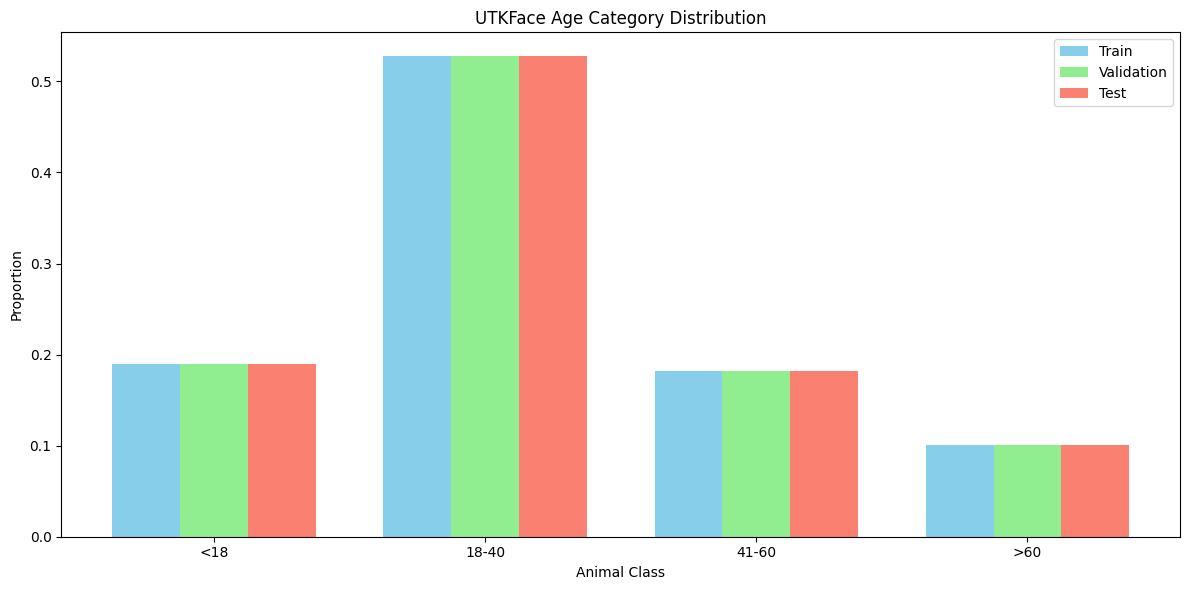

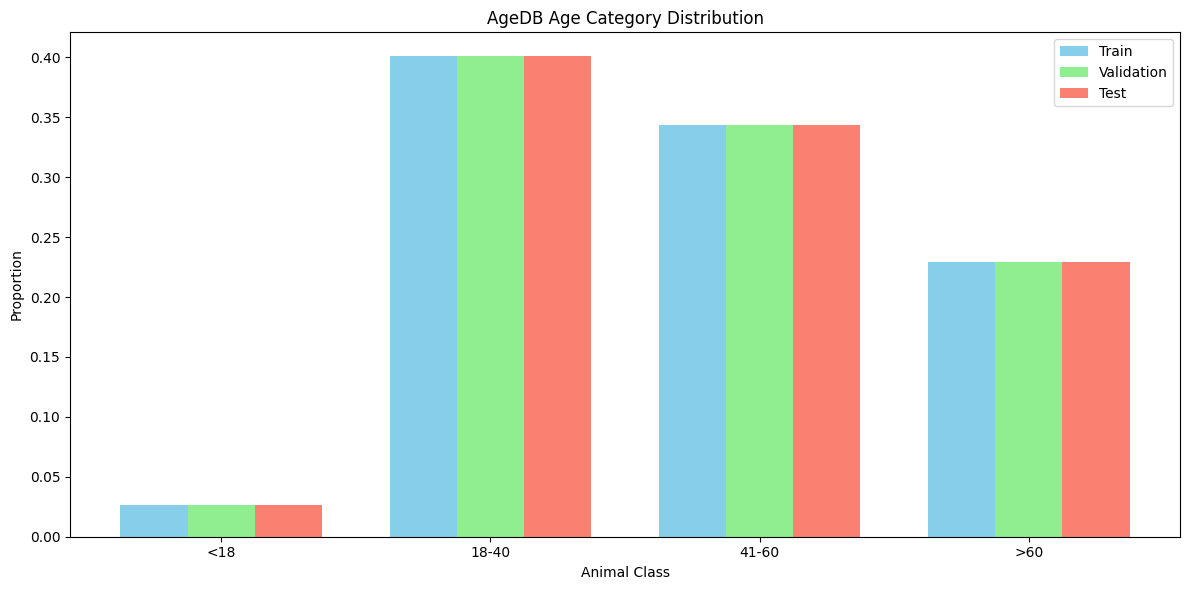

In [6]:
# Create train-test splits (for both datasets)
utkface_train_val_X, utkface_test_X, utkface_train_val_y, utkface_test_y = train_test_split(utkface_df['image_path'], utkface_df['age_category'], test_size=0.2, random_state=42, stratify=utkface_df['age_category'])
utkface_train_X, utkface_val_X, utkface_train_y, utkface_val_y = train_test_split(utkface_train_val_X, utkface_train_val_y, test_size=0.25, shuffle=True, random_state=42, stratify=utkface_train_val_y)
# Plot class distribution for UTKFace
plot_class_distribution(utkface_train_y, utkface_val_y, utkface_test_y, title="UTKFace Age Category Distribution")

agedb_train_val_X, agedb_test_X, agedb_train_val_y, agedb_test_y = train_test_split(agedb_df['image_path'], agedb_df['age_category'], test_size=0.2, random_state=42, stratify=agedb_df['age_category'])
agedb_train_X, agedb_val_X, agedb_train_y, agedb_val_y = train_test_split(agedb_train_val_X, agedb_train_val_y, test_size=0.25, shuffle=True, random_state=42, stratify=agedb_train_val_y)
# Plot class distribution for AgeDB
plot_class_distribution(agedb_train_y, agedb_val_y, agedb_test_y, title="AgeDB Age Category Distribution")

Create class_weights (later for the loss function) to deal with unbalanced classes:

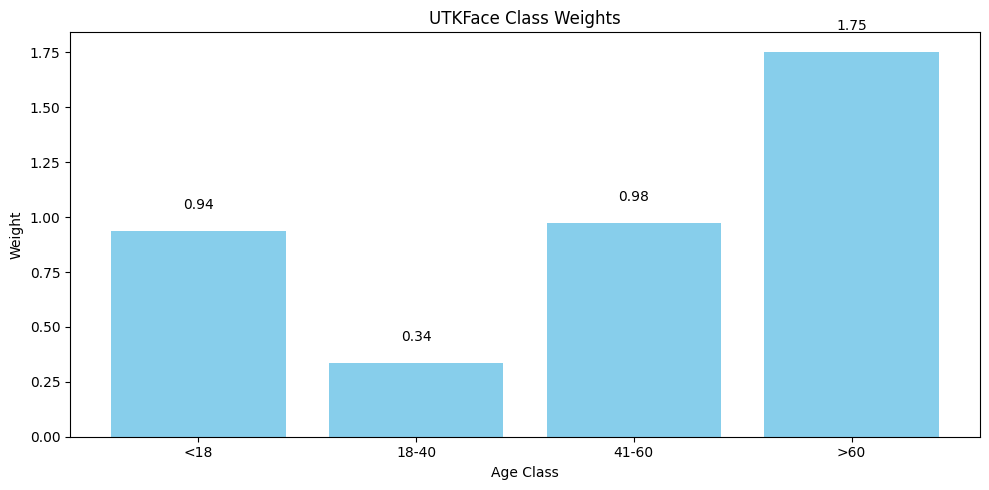

Class weights tensor: tensor([0.9350, 0.3361, 0.9752, 1.7537], device='cuda:0')


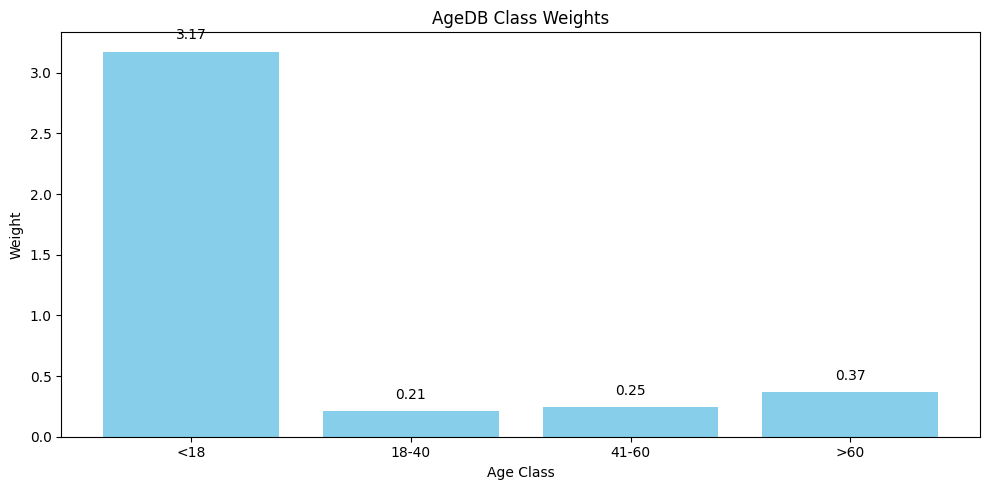

Class weights tensor: tensor([3.1750, 0.2106, 0.2456, 0.3688], device='cuda:0')


In [7]:
# Create class weights for both datasets
utkface_class_weights = create_class_weights(utkface_train_y, 4)
plot_class_weights(utkface_class_weights, utkface_train_y, title="UTKFace Class Weights")
# Convert class weights to a pytorch tensor
utkface_class_weights_tensor = torch.FloatTensor(utkface_class_weights).to(device)
print("Class weights tensor:", utkface_class_weights_tensor)

agedb_class_weights = create_class_weights(agedb_train_y, 4)
plot_class_weights(agedb_class_weights, agedb_train_y, title="AgeDB Class Weights")
# Convert class weights to a pytorch tensor
agedb_class_weights_tensor = torch.FloatTensor(agedb_class_weights).to(device)
print("Class weights tensor:", agedb_class_weights_tensor)


Create Datasets from both splits:

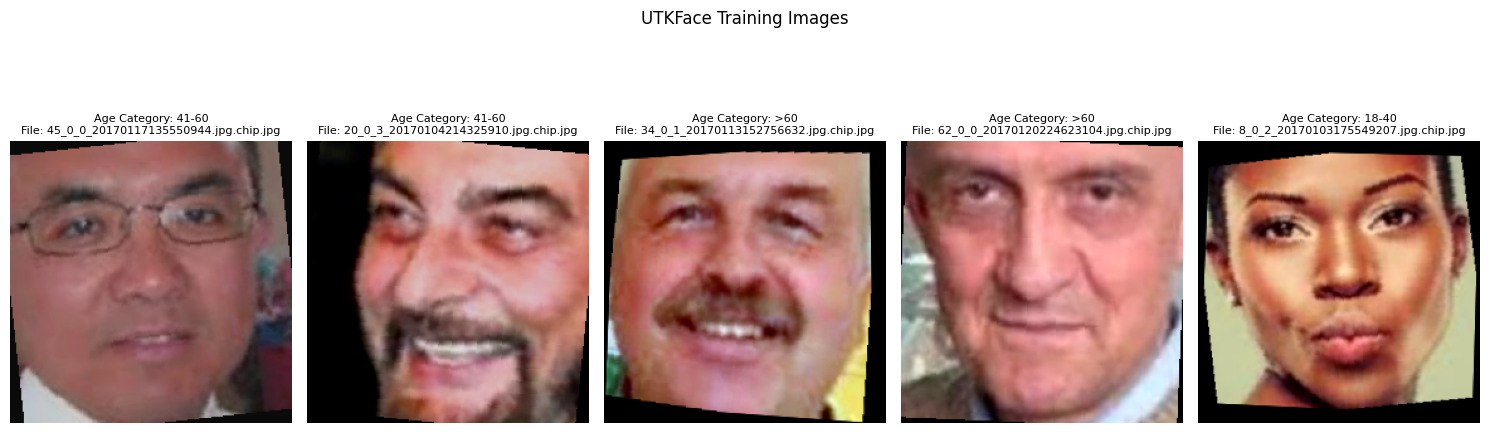

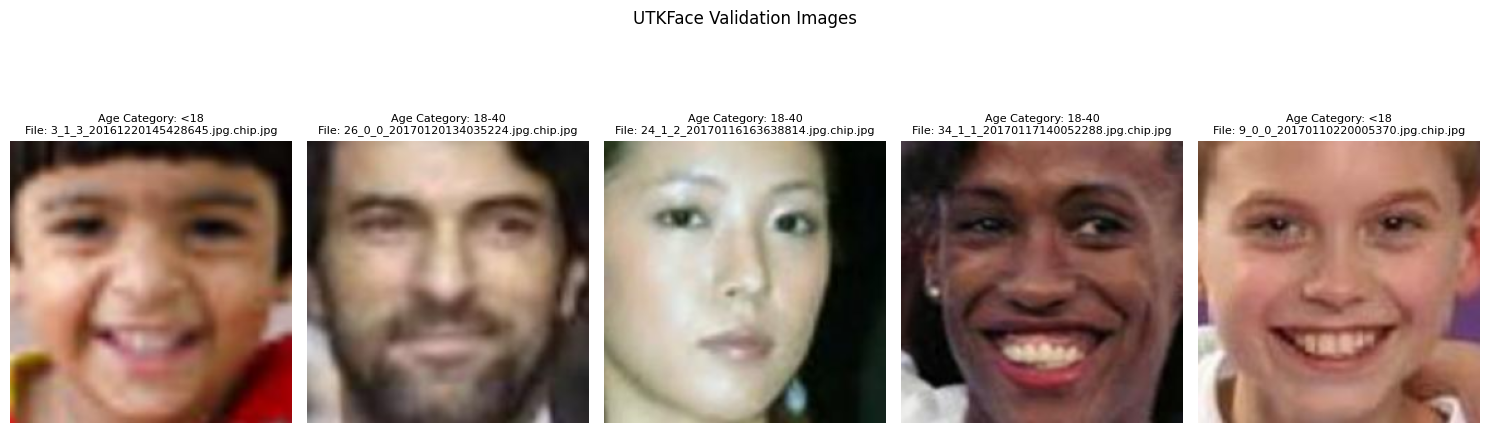

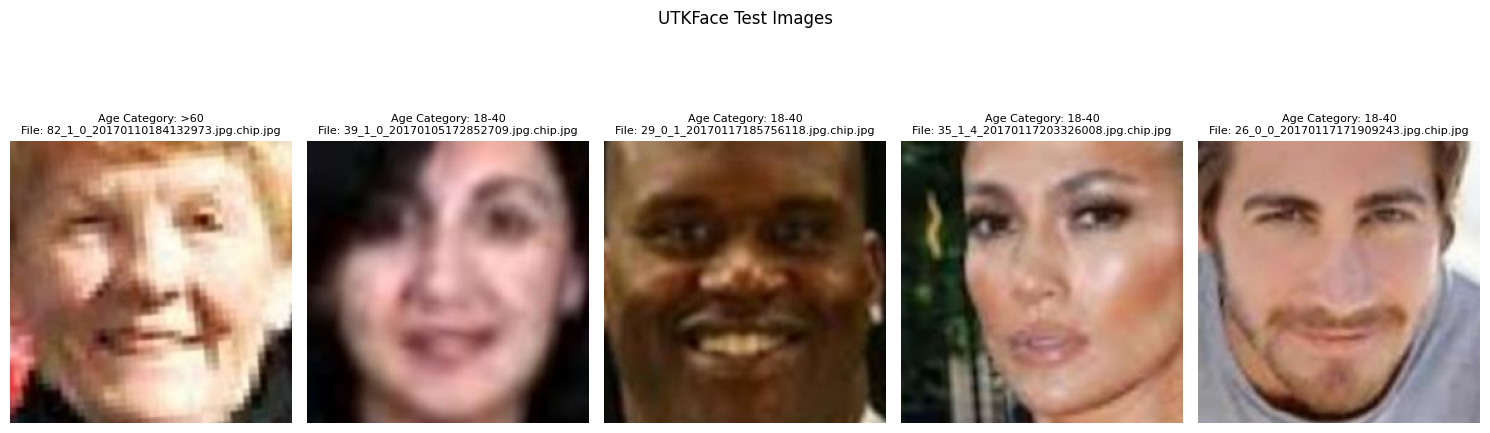

In [ ]:
# Create dataloader for both datasets
utkface_train_dataset, utkface_train_loader = create_datasets_loader(X=utkface_train_X, y=utkface_train_y, transform=transform_train, batch_size=256, shuffle=True, num_workers=0)
utkface_val_dataset, utkface_val_loader = create_datasets_loader(X=utkface_val_X, y=utkface_val_y, transform=transform_test, batch_size=256, shuffle=False, num_workers=0)
utkface_test_dataset, utkface_test_loader = create_datasets_loader(X=utkface_test_X, y=utkface_test_y, transform=transform_test, batch_size=256, shuffle=False, num_workers=0)

plot_images_with_labels_and_filenames(data_loader=utkface_train_loader, dataset=utkface_train_dataset, num_images=5, title="UTKFace Training Images")
print("Hint: The paths of the training images are not matching, because the dataloader was shuffled. This is expected behavior.")
plot_images_with_labels_and_filenames(data_loader=utkface_val_loader, dataset=utkface_val_dataset, num_images=5, title="UTKFace Validation Images")
plot_images_with_labels_and_filenames(data_loader=utkface_test_loader, dataset=utkface_test_dataset, num_images=5, title="UTKFace Test Images")

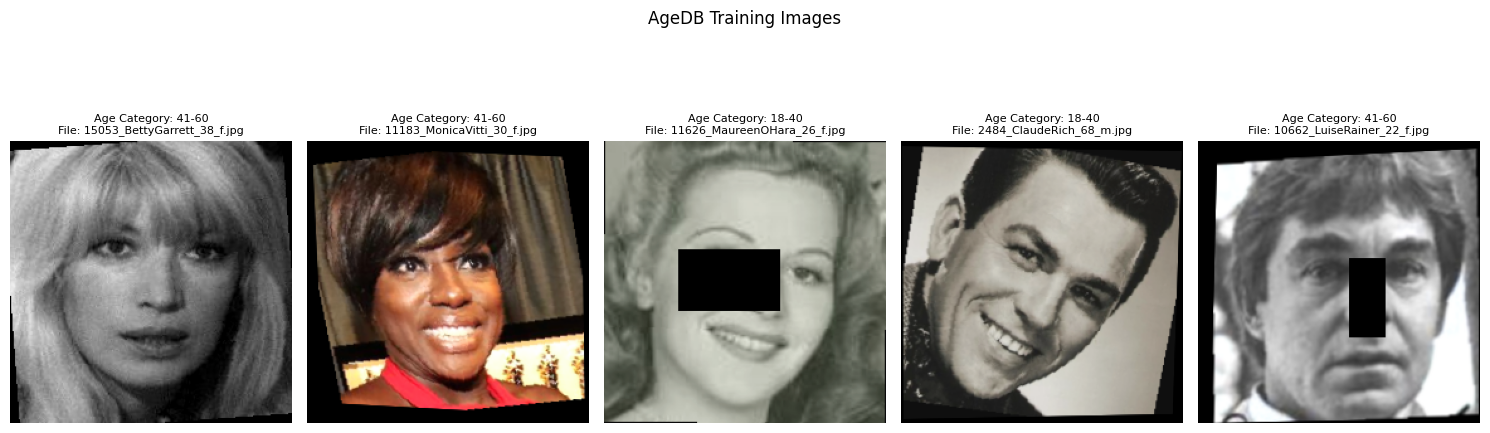

Hint: The paths of the training images are not matching, because the dataloader was shuffled. This is expected behavior.


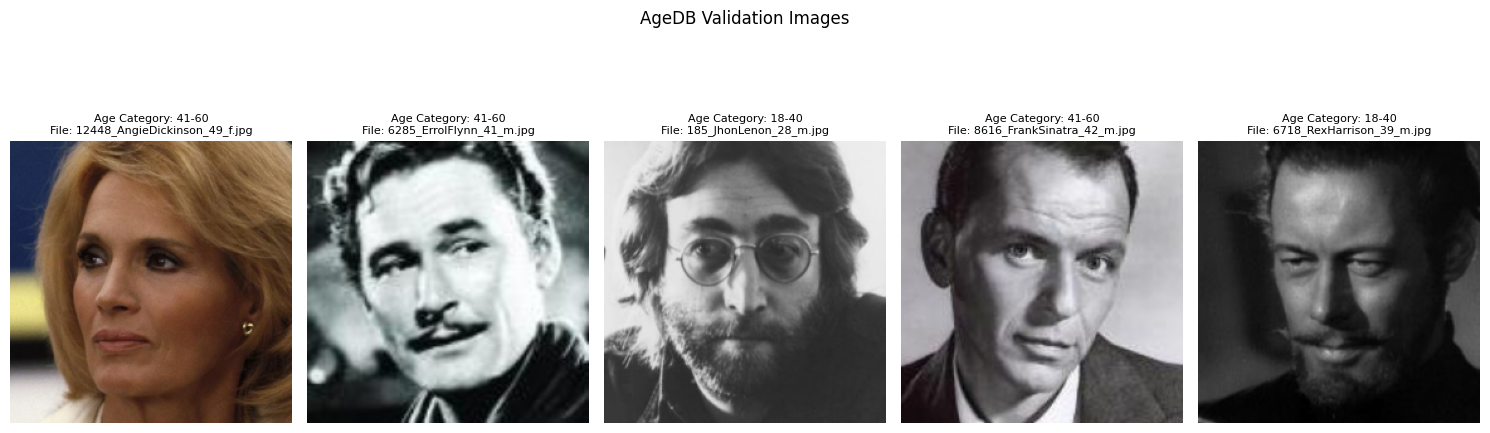

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.018562138..1.0000001].


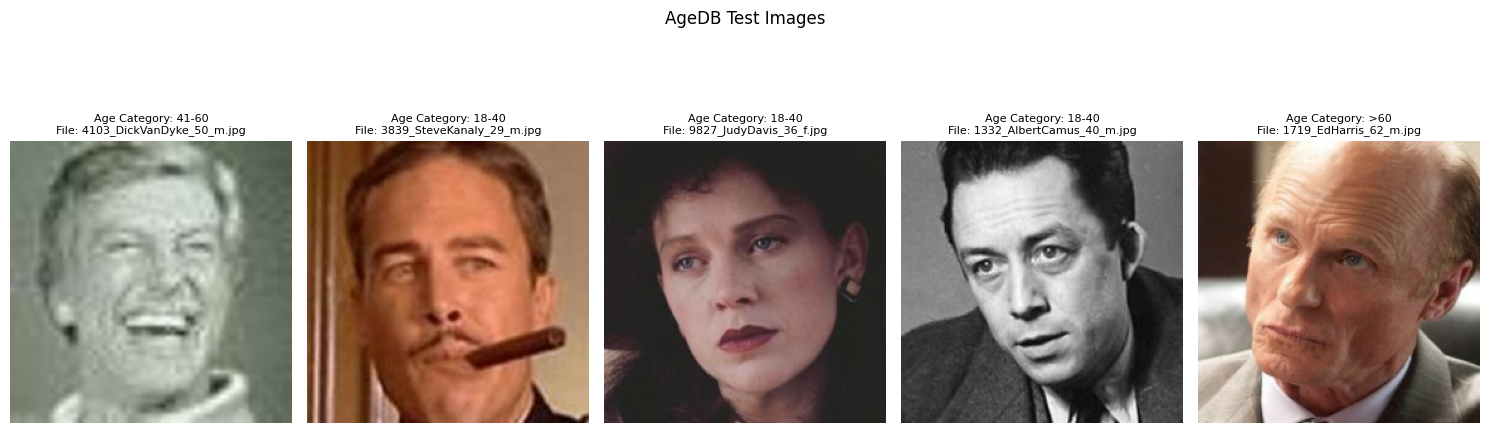

In [15]:

agedb_train_dataset, agedb_train_loader = create_datasets_loader(X=agedb_train_X, y=agedb_train_y, transform=transform_train, batch_size=256, shuffle=True, num_workers=0)
agedb_val_dataset, agedb_val_loader = create_datasets_loader(X=agedb_val_X, y=agedb_val_y, transform=transform_test, batch_size=256, shuffle=False, num_workers=0)
agedb_test_dataset, agedb_test_loader = create_datasets_loader(X=agedb_test_X, y=agedb_test_y, transform=transform_test, batch_size=256, shuffle=False, num_workers=0)

plot_images_with_labels_and_filenames(agedb_train_loader, agedb_train_dataset, num_images=5, title="AgeDB Training Images")
print("Hint: The paths of the training images are not matching, because the dataloader was shuffled. This is expected behavior.")
plot_images_with_labels_and_filenames(agedb_val_loader, agedb_val_dataset, num_images=5, title="AgeDB Validation Images")
plot_images_with_labels_and_filenames(agedb_test_loader, agedb_test_dataset, num_images=5, title="AgeDB Test Images")

## 3. Build CoAtNet

TODO:
- [ ] import via timm (the model already exists there)
- [ ] adjust for pre-training
- [ ] adjust for fine-tuning

## 4. Pre-Training

> Hint 1: Use the dataloader created in [Load and prepare Datasets](#2-load-and-prepare-datasets)
> Hint 2: Use the base model created in [Build CoAtNet](#3-build-coatnet) and maybe adjust for your SSL approach

TODO:
- [ ] adjust base model for SSL approach
- [ ] create train loop
- [ ] train
- [ ] save best run --> pre-trained model
- [ ] evaluate

## 5. Fine-Tuning

> Hint 1: Use the dataloader created in [Load and prepare Datasets](#2-load-and-prepare-datasets)
> Hint 2: Use the pre-trained model created in [Build CoAtNet](#3-build-coatnet) and maybe adjust for the classification task

TODO:
- [ ] adjust pre-trained model for classification head
- [ ] create train loop
- [ ] train
- [ ] save best run --> final fine-tuned model
- [ ] evaluate (with our images)